In [1]:
import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Chapter 6: Monte Carlo simulations in finance

## Simulating stock price dynamics using Geometric Brownian Motion

### How to do it...

1. Import libraries:

In [5]:
import numpy as np
import pandas as pd
# import yfinance as yf
from pandas_datareader import data
from matplotlib.ticker import FuncFormatter

2. Define parameters for downloading data:

In [6]:
RISKY_ASSET = 'MSFT'
START_DATE = '2019-01-01'
END_DATE = '2019-07-31'

3. Download data from Yahoo Finance:

In [8]:
# df = yf.download(RISKY_ASSET, start=START_DATE, 
#                  end=END_DATE, adjusted=True)

df = data.DataReader(RISKY_ASSET,'yahoo', START_DATE, END_DATE)

print(f'Downloaded {df.shape[0]} rows of data.')

Downloaded 147 rows of data.


4. Calculate daily returns:

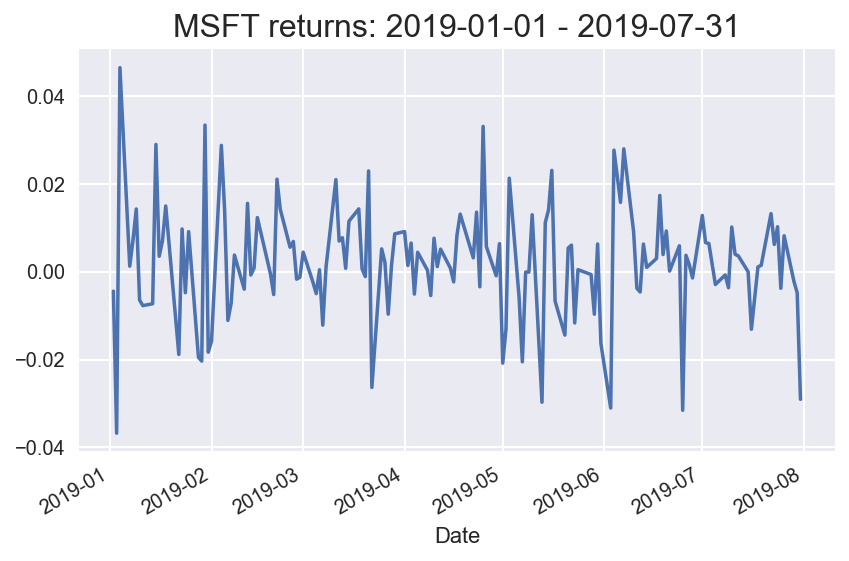

Average return: 0.22%


In [9]:
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()

ax = returns.plot()
ax.set_title(f'{RISKY_ASSET} returns: {START_DATE} - {END_DATE}', 
             fontsize=16)

plt.tight_layout()
# plt.savefig('images/ch6_im1.png')
plt.show()

print(f'Average return: {100 * returns.mean():.2f}%')

5. Split data into the training and test sets:

In [10]:
train = returns['2019-01-01':'2019-06-30']
test = returns['2019-07-01':'2019-07-31']

6. Specify the parameters of the simulation:

In [11]:
T = len(test)
N = len(test)
S_0 = adj_close[train.index[-1]]
N_SIM = 100
mu = train.mean()
sigma = train.std()

7. Define the function used for simulations:

In [12]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                 random_seed=42):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    np.random.seed(random_seed)
    
    dt = T/N
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps 
                       + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)
    
    return S_t

8. Run the simulations:

In [13]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

9. Plot simulation results:

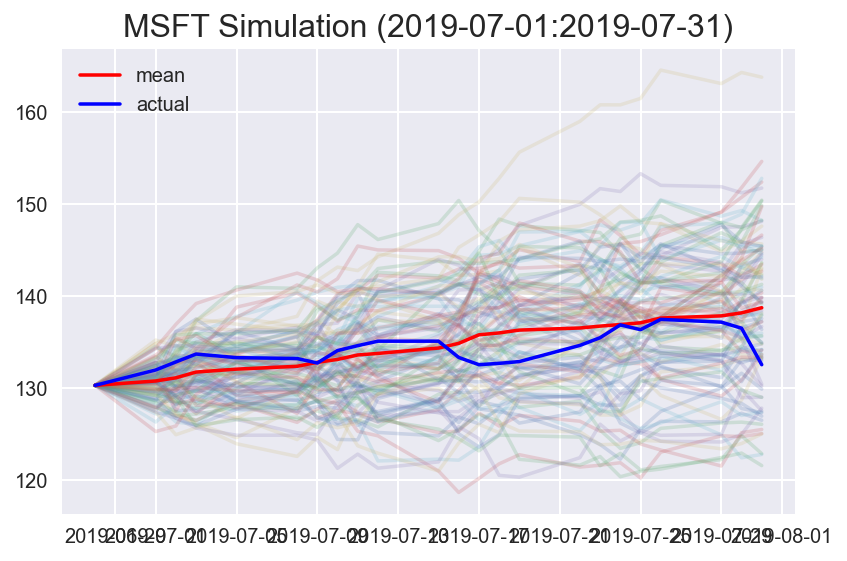

In [15]:
# prepare objects for plotting 
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation '
              f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), 
                                  index=index)

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
# plt.savefig('images/ch6_im2.png')
plt.show()

### There's more 

In [16]:
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

129 µs ± 775 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [17]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42, antithetic_var=False):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility
    antithetic_var : bool
        Boolean whether to use antithetic variates approach to reduce variance

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    
    np.random.seed(random_seed)
    
    # time increment
    dt = T/N
    
    # Brownian
    if antithetic_var:
        dW_ant = np.random.normal(scale = np.sqrt(dt), 
                                  size=(int(n_sims/2), N + 1))
        dW = np.concatenate((dW_ant, -dW_ant), axis=0)
    else: 
        dW = np.random.normal(scale = np.sqrt(dt),
                              size=(n_sims, N + 1))
  
    # simulate the evolution of the process
    S_t = s_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dW,
                                 axis=1))
    S_t[:, 0] = s_0
    
    return S_t

In [18]:
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

90.5 µs ± 706 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [19]:
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N, antithetic_var=True)

64.8 µs ± 644 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Estimating Value-at-risk using Monte Carlo

### How to do it...

1. Import libraries:

In [20]:
import numpy as np
import pandas as pd
# import yfinance as yf
import seaborn as sns

In [21]:
# set random seed for reproducibility
np.random.seed(42)

2. Define the parameters that will be used for this exercise:

In [62]:
RISKY_ASSETS = ['GOOG', 'FB', 'AMZN']
SHARES = [5, 5 ,5]
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'
T = 1
N_SIMS = 10 ** 5

3. Download data from Yahoo Finance:

In [63]:
# df = yf.download(RISKY_ASSETS, start=START_DATE, 
#                  end=END_DATE, adjusted=True)

df = data.DataReader(RISKY_ASSETS,'yahoo', START_DATE, END_DATE)

print(f'Downloaded {df.shape[0]} rows of data.')

Downloaded 251 rows of data.


In [64]:
df.head()

Attributes    Adj Close                                 Close              \
Symbols            GOOG          FB         AMZN         GOOG          FB   
Date                                                                        
2018-01-02  1065.000000  181.419998  1189.010010  1065.000000  181.419998   
2018-01-03  1082.479980  184.669998  1204.199951  1082.479980  184.669998   
2018-01-04  1086.400024  184.330002  1209.589966  1086.400024  184.330002   
2018-01-05  1102.229980  186.850006  1229.140015  1102.229980  186.850006   
2018-01-08  1106.939941  188.279999  1246.869995  1106.939941  188.279999   

Attributes                      High                                   Low  \
Symbols            AMZN         GOOG          FB         AMZN         GOOG   
Date                                                                         
2018-01-02  1189.010010  1066.939941  181.580002  1190.000000  1045.229980   
2018-01-03  1204.199951  1086.290039  184.779999  1205.489990  1063.209961   
2018-01-04  1209.589966  1093.569946  186.210007  1215.869995  1084.001953   
2018-01-05  1229.140015  1104.250000  186.899994  1229.140015  1092.000000   
2018-01-08  1246.869995  1111.270020  188.899994  1253.079956  1101.619995   

Attributes                                  Open                           \
Symbols             FB         AMZN         GOOG          FB         AMZN   
Date                                                                        
2018-01-02  177.550003  1170.510010  1048.339966  177.679993  1172.000000   
2018-01-03  181.330002  1188.300049  1064.310059  181.880005  1188.300049   
2018-01-04  184.100006  1204.660034  1088.000000  184.899994  1205.000000   
2018-01-05  184.929993  1210.000000  1094.000000  185.589996  1217.510010   
2018-01-08  186.330002  1232.030029  1102.229980  187.199997  1236.000000   

Attributes   Volume                     
Symbols        GOOG        FB     AMZN  
Date                                    
2018-01-02  1237600  18151900  2694500  
2018-01-03  1430200  16886600  3108800  
2018-01-04  1004600  13880900  3022100  
2018-01-05  1279100  13574500  3544700  
2018-01-08  1047600  17994700  4279500

4. Calculate daily returns:

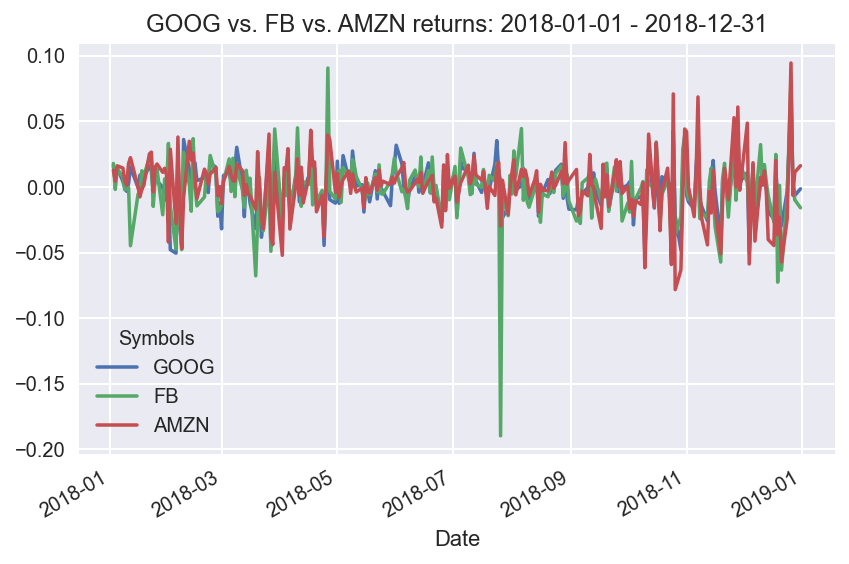

Correlation between returns: 0.62


In [65]:
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()
plot_title = f'{" vs. ".join(RISKY_ASSETS)} returns: {START_DATE} - {END_DATE}'
returns.plot(title=plot_title)

plt.tight_layout()
# plt.savefig('images/ch6_im3.png')
plt.show()

print(f'Correlation between returns: {returns.corr().values[0,1]:.2f}')

5. Calculate the covariance matrix:

In [66]:
cov_mat = returns.cov()
cov_mat

Symbols,GOOG,FB,AMZN
Symbols,,,
GOOG,0.000314,0.000264,0.000303
FB,0.000264,0.000574,0.000315
AMZN,0.000303,0.000315,0.000518


6. Perform the Cholesky decomposition of the covariance matrix:

In [67]:
chol_mat = np.linalg.cholesky(cov_mat)
chol_mat

array([[0.01772364, 0.        , 0.        ],
       [0.01490303, 0.01874656, 0.        ],
       [0.01708228, 0.00323699, 0.01470068]])

7. Draw correlated random numbers from Standard Normal distribution:

In [68]:
rv = np.random.normal(size=(N_SIMS, len(RISKY_ASSETS)))
correlated_rv = np.transpose(np.matmul(chol_mat, np.transpose(rv)))

8. Define metrics used for simulations:

In [69]:
r = np.mean(returns, axis=0).values
sigma = np.std(returns, axis=0).values
S_0 = adj_close.values[-1, :]
P_0 = np.sum(SHARES * S_0)

9. Calculate the terminal price of the considered stocks:

In [70]:
S_T = S_0 * np.exp((r - 0.5 * sigma ** 2) * T + 
                   sigma * np.sqrt(T) * correlated_rv)

10. Calculate the terminal portfolio value and calculate the portfolio returns:

In [71]:
P_T = np.sum(SHARES * S_T, axis=1)
P_diff = P_T - P_0

11. Calculate VaR:

In [72]:
P_diff_sorted = np.sort(P_diff)
percentiles = [0.01, 0.1, 1.]
var = np.percentile(P_diff_sorted, percentiles)

for x, y in zip(percentiles, var):
    print(f'1-day VaR with {100-x}% confidence: {-y:.2f}$')

1-day VaR with 99.99% confidence: 14.72$
1-day VaR with 99.9% confidence: 11.34$
1-day VaR with 99.0% confidence: 7.10$


12. Present the results on a graph:

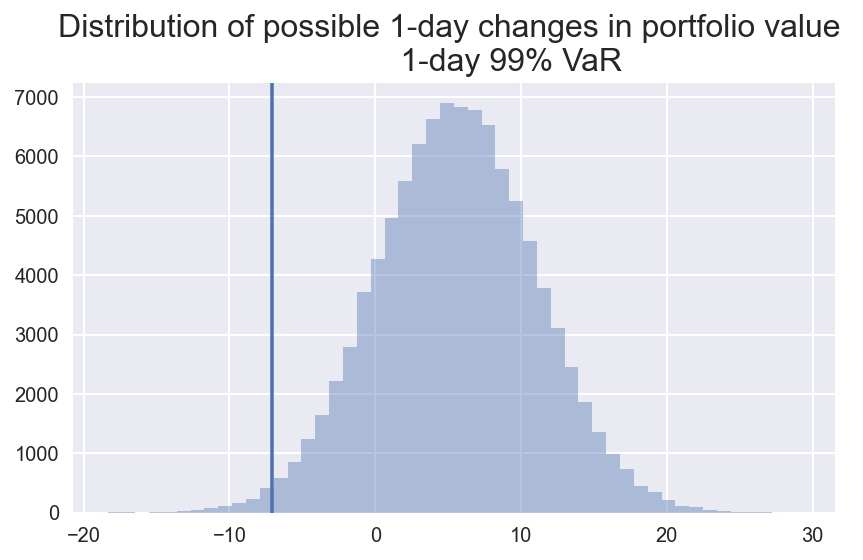

In [73]:
ax = sns.distplot(P_diff, kde=False)
ax.set_title('''Distribution of possible 1-day changes in portfolio value 
             1-day 99% VaR''', fontsize=16)
ax.axvline(var[2], 0, 10000)

plt.tight_layout()
# plt.savefig('images/ch6_im4.png')
plt.show()

### There's more

In [74]:
var = np.percentile(P_diff_sorted, 5)
expected_shortfall = P_diff_sorted[P_diff_sorted<=var].mean()

print(f'The 1-day 95% VaR is {-var:.2f}$, and the accompanying Expected Shortfall is {-expected_shortfall:.2f}$.')

The 1-day 95% VaR is 3.35$, and the accompanying Expected Shortfall is 5.66$.
